In [42]:
import os
from dotenv import load_dotenv
from langchain_upstage import ChatUpstage
load_dotenv()

llm = ChatUpstage(api_key=os.getenv("SOLAR_API_KEY"), model='solar-pro')

In [43]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: Annotated[str, "The sender of the last message"]
    score: Annotated[dict, "The final score of inspector"]
    

In [44]:
from typing import Annotated
from langchain_teddynote.tools.tavily import TavilySearch

In [45]:
import json
from langchain.tools import tool

@tool
def fetch_from_db(input: str) -> str:
    """ 입력: 회사명 
        출력: DB 속 회사에 대한 정보"""
    
    dummy_db = {
        "핀업": {
            "url": "https://www.innoforest.co.kr/company/CP00011911/핀업",
            "기업명": "핀업",
            "기업소개": "주식 종목 추천 및 투자 강의 플랫폼 '핀업' 운영 기업",
            "상장여부": "비상장",
            "설립일": "2015-06-30",
            "홈페이지": "http://stock.finup.co.kr/",
            "주소": "서울 강남구",
            "카테고리": ["금융/보험/핀테크", "AI/딥테크/블록체인", "교육", "투자"],
            "자본금": "7.0억원",
            "고용인원": "21명",
            "연매출": "98.5억원",
            "영업이익": "8.9억",
            "순이익": "1.1억",
            "자산": "277.2억",
            "부채": "165.7억",
            "자본": "111.6억"
        }
    }
    result = dummy_db.get(input)
    if result:
        return json.dumps(result, ensure_ascii=False, indent=2)
    return f"'{input}'에 대한 정보가 없습니다."

@tool
def search_web(input: str) -> str:
    """지금은 데모 단계라서 사용하지 않음"""
    if input.strip() != "핀업":
        return f"'{input}'에 대한 웹 검색은 허용되지 않습니다. 검색 가능한 회사는 '핀업'뿐입니다."
    return f"[MOCKED] 핀업에 대한 추가 웹 검색 결과가 없습니다."


In [46]:
sellside_prompt = """
    당신은 친절한 {company_name}의 M&A 매도자입니다. 당신의 역할은 평가자가 요청한 정보를 정확히 제공하는 것입니다.
    도구 사용 규칙:
    1. 반드시 fetch_from_db 도구를 먼저 시도하세요.
    2. search_web 도구는 오직 DB에 정보가 없을 경우에만 사용하세요.
    3. 상상을 포함하지 말고, 반드시 사실만 기반으로 응답하세요.
"""

company_name = "핀업"

def get_sellside_prompt(company_name: str) -> str:
    return sellside_prompt.format(company_name=company_name)

In [47]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

sellside_agent = create_react_agent(
    llm, 
    tools=[fetch_from_db, search_web],
    prompt=get_sellside_prompt(company_name),
)

def sellside_node(state: State) -> State:
    result = sellside_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content,
        name="sellside",
    )
    return {
        "messages": [last_message]
    }

In [48]:
inspector_prompt = """
    당신은 엄격한 체크리스트 기반 M&A 평가 전문가입니다.
    회사 '{company_name}'의 M&A 평가를 위해 체크리스트를 검토하고 있습니다.
    다음은 체크리스트 항목과 항목별 배점입니다:
    {checklist}

    매수자의 요청:
    {user_query}

    이 정보를 기반으로 아래 JSON 형식으로 응답하세요:
    {{
        "question": "질문 내용",
        "final_score": {{"항목1": 10, "항목2": 20, ...}}
    }}

    단, 정보가 부족하거나 모호한 항목이 있다면 "question"에 질문 내용을 작성하고 "final_score"는 빈 문자열로 반환하세요.
    대답을 충분히 듣고 평가하기에 정보가 충분하다고 판단되면 "question"은 빈 문자열로 설정하고 "final_score"에 항목별 점수를 JSON 형식으로 작성하세요.
"""
checklist={
    "업종": 20,
    "연매출": 15,
    "투자유치": 25,
    "부채비율": 30,
    "영업이익률": 10
}

user_query = "헬스케어 산업에 종사하는, 연매출 100억 이상, 최근 1년 투자금 100억 이상, 작년 성장률 25% 이상, 영업이익률 10% 이상인 기업을 찾고 있습니다."

def get_inspector_prompt(company_name: str) -> str:
    return inspector_prompt.format(company_name=company_name,checklist=checklist, user_query=user_query)

In [49]:
inspector_agent = create_react_agent(
    llm, 
    tools=[fetch_from_db, search_web],
    prompt=get_inspector_prompt(company_name),
)

def inspector_node(state: State) -> State:
    result =inspector_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content,
        name="checklist_inspector",
    )
    return {
        "messages": [last_message]
    }

In [50]:
from langgraph.graph import END
def router(state: State):
    if state["sender"] == "sellside":
        return "continue"
    elif state["sender"] == "checklist_inspector":
        if state["score"]:
            return END
        else:
            # 질문이 없는 경우
            return "continue"
    else:
        raise ValueError("Unknown sender")

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)
workflow.add_node("checklist_inspector", inspector_node)
workflow.add_node("sellside", sellside_node)
workflow.add_edge(START, "checklist_inspector")
workflow.add_edge("sellside", "checklist_inspector")
workflow.add_conditional_edges(
    "checklist_inspector",
    router,
    {
        "continue": "sellside",
        END: END,
    },
)
app = workflow.compile(checkpointer=MemorySaver())


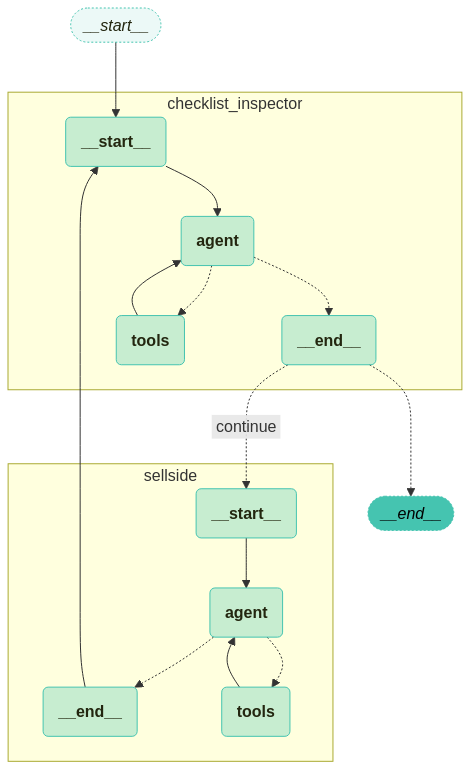

In [56]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph
from langchain_core.messages import HumanMessage

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 초기 상태 설정
inputs = {
    "messages": [
        HumanMessage(
            content="안녕하세요, 핀업에 대한 M&A 평가 점수를 요청합니다."
        ),
    ],
    "score": {}
}

invoke_graph(app, inputs, config, node_names=["sellside", "checklist_inspector"])


TypeError: invoke_graph() missing 1 required positional argument: 'inputs'